In [370]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from PIL import Image

In [371]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [372]:
transform = torchvision.transforms.Compose(transforms=[
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize(size=(500, 500)),
    torchvision.transforms.ToTensor(),
])

In [373]:
def get_rot_mat(theta, device):
    theta_cos = torch.cos(input=theta)
    theta_sin = torch.sin(input=theta)
    zeros = torch.zeros_like(input=theta_cos).to(device)
    return torch.stack(tensors=[theta_cos, -theta_sin, zeros, theta_sin, theta_cos, zeros]).view(2,3)

In [374]:
def rot_img(x, theta, device):
    rot_mat = get_rot_mat(theta=theta, device=device).unsqueeze(dim=0).repeat(x.shape[0],1,1)    # repeat for whole batch
    grid = F.affine_grid(theta=rot_mat, size=x.size(), align_corners=False)
    x = F.grid_sample(input=x, grid=grid, align_corners=False)
    return x

In [375]:
def convert_img_to_gray(image, path=None):
    imgGray = image.convert('L')
    if path:
        imgGray.save(path)
    return imgGray

In [376]:
im_in = Image.open('images/test_seven.jpg')
im_out = Image.open('images/test_seven_2.jpg')
im_in = convert_img_to_gray(im_in, 'images/test_seven_grey.jpg')
im_out = convert_img_to_gray(im_out, 'images/test_seven_2_grey.jpg')

In [377]:
transformation = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
#     transforms.Normalize(mean=0.5, std=0.5)
])

In [378]:
im_in = transformation(Image.open('images/test_seven_grey.jpg'))

im_out = transformation(Image.open('images/test_seven_2_grey.jpg'))

In [379]:
im_in.shape

torch.Size([1, 32, 32])

In [380]:
im_out.shape

torch.Size([1, 32, 32])

<Figure size 432x288 with 0 Axes>

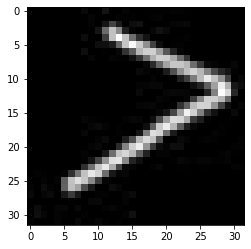

<Figure size 432x288 with 0 Axes>

In [381]:
plt.imshow(im_in.detach().cpu().permute(1,2,0), cmap='gray')
plt.figure()

<Figure size 432x288 with 0 Axes>

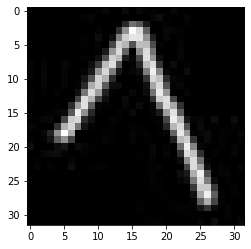

<Figure size 432x288 with 0 Axes>

In [382]:
plt.imshow(im_out.detach().cpu().permute(1,2,0), cmap='gray')
plt.figure()

# Sieć

In [384]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from datetime import datetime 

import matplotlib.pyplot as plt

In [421]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 1
N_EPOCHS = 1000
IMG_SIZE = 32

In [386]:
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [387]:
def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [388]:
def training_loop(model, criterion, optimizer, train_loader, epochs, device, print_every=10):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        if epoch % print_every == (print_every - 1):
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, train_losses

In [389]:
im_in

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0431, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0510, 0.0235,  ..., 0.0000, 0.0000, 0.0000],
         [0.0157, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])

In [390]:
from torch.utils.data import Dataset

In [391]:
class CustomTestDataset(Dataset):
    def __init__(self, image_in, image_out):
        self.img_labels = (image_in, image_out)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return self.img_labels[0], self.img_labels[1]

In [392]:
train_loader = DataLoader(dataset=CustomTestDataset(im_in, im_out), 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

In [393]:
next(iter(train_loader))

[tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0431, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0510, 0.0235,  ..., 0.0000, 0.0000, 0.0000],
           [0.0157, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]]),
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0196, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0196, 0.0000, 0.0078],
           [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0314]]]])]

In [422]:
class LeNet5(nn.Module):

    def __init__(self, device):
        super().__init__()
        
        self.device = device
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.BatchNorm2d(6),
            nn.MaxPool2d(kernel_size=3),
#             nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
#             nn.Tanh(),
#             nn.MaxPool2d(kernel_size=2),
#             nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
#             nn.Tanh()
        )

        self.classifier = nn.Sequential(
#             nn.Linear(in_features=120, out_features=84),
#             nn.Tanh(),
            nn.Linear(in_features=486, out_features=20),
            nn.Tanh(),
            nn.Linear(in_features=20, out_features=1)
        )


    def forward(self, x_inp):
        x = self.feature_extractor(x_inp)
#         print(x.shape)
        x = torch.flatten(x, 1)
        theta = self.classifier(x)
#         print(f"theta: {theta}")
        rotated_x = rot_img(x=x_inp, theta=theta, device=self.device)
        return rotated_x

In [423]:
type(train_dataset)

torchvision.datasets.mnist.MNIST

In [424]:
next(iter(train_loader))[0].max()

tensor(0.9137)

In [429]:
torch.manual_seed(RANDOM_SEED)
model = LeNet5(device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, N_EPOCHS, device)

17:20:22 --- Epoch: 9	Train loss: 0.0457
17:20:22 --- Epoch: 19	Train loss: 0.0424
17:20:22 --- Epoch: 29	Train loss: 0.0427
17:20:22 --- Epoch: 39	Train loss: 0.0422
17:20:22 --- Epoch: 49	Train loss: 0.0423
17:20:22 --- Epoch: 59	Train loss: 0.0422
17:20:22 --- Epoch: 69	Train loss: 0.0422
17:20:22 --- Epoch: 79	Train loss: 0.0422
17:20:22 --- Epoch: 89	Train loss: 0.0422
17:20:22 --- Epoch: 99	Train loss: 0.0422
17:20:23 --- Epoch: 109	Train loss: 0.0422
17:20:23 --- Epoch: 119	Train loss: 0.0422
17:20:23 --- Epoch: 129	Train loss: 0.0422
17:20:23 --- Epoch: 139	Train loss: 0.0422
17:20:23 --- Epoch: 149	Train loss: 0.0422
17:20:23 --- Epoch: 159	Train loss: 0.0422
17:20:23 --- Epoch: 169	Train loss: 0.0422
17:20:23 --- Epoch: 179	Train loss: 0.0422
17:20:23 --- Epoch: 189	Train loss: 0.0422
17:20:23 --- Epoch: 199	Train loss: 0.0422
17:20:23 --- Epoch: 209	Train loss: 0.0422
17:20:23 --- Epoch: 219	Train loss: 0.0422
17:20:23 --- Epoch: 229	Train loss: 0.0422
17:20:23 --- Epoch: 23

NameError: name 'plot_losses' is not defined

In [430]:
with torch.no_grad():
    y = model(next(iter(train_loader))[0].to(device))

In [431]:
y

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0106, 0.0348, 0.0273],
          [0.0000, 0.0000, 0.0000,  ..., 0.0070, 0.0158, 0.0140],
          [0.0000, 0.0000, 0.0000,  ..., 0.0011, 0.0000, 0.0013]]]],
       device='cuda:0')

<Figure size 432x288 with 0 Axes>

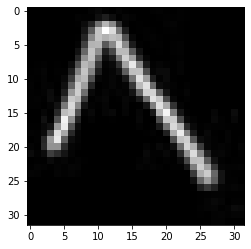

<Figure size 432x288 with 0 Axes>

In [432]:
plt.imshow(y.detach().cpu().squeeze(0).permute(1,2,0), cmap='gray')
plt.figure()